Using device: cuda:0
Training the model...
Epoch [1/10], Loss: 0.4999, Learning Rate: 0.001000
Validation Accuracy for Epoch 1: 94.32%
Confusion Matrix for Epoch 1
[[  79    0    0   13    0    0]
 [   0  654    2    1    1    0]
 [   0    0  155    1    0    3]
 [   0    0    0   87    0    0]
 [   9    5    0   46  831   38]
 [  11    3   12   22   16 1230]]
Best model saved with Validation Accuracy: 94.32%
Epoch [2/10], Loss: 0.2621, Learning Rate: 0.001000
Validation Accuracy for Epoch 2: 96.02%
Confusion Matrix for Epoch 2
[[  88    0    0    3    0    1]
 [   0  657    0    0    1    0]
 [   0    2  153    3    1    0]
 [   0    0    0   87    0    0]
 [  10    9    1   19  881    9]
 [   3    5   29    6   26 1225]]
Best model saved with Validation Accuracy: 96.02%
Epoch [3/10], Loss: 0.1751, Learning Rate: 0.001000
Validation Accuracy for Epoch 3: 95.99%
Confusion Matrix for Epoch 3
[[  91    0    0    0    0    1]
 [   0  651    7    0    0    0]
 [   0    0  159    0    0    

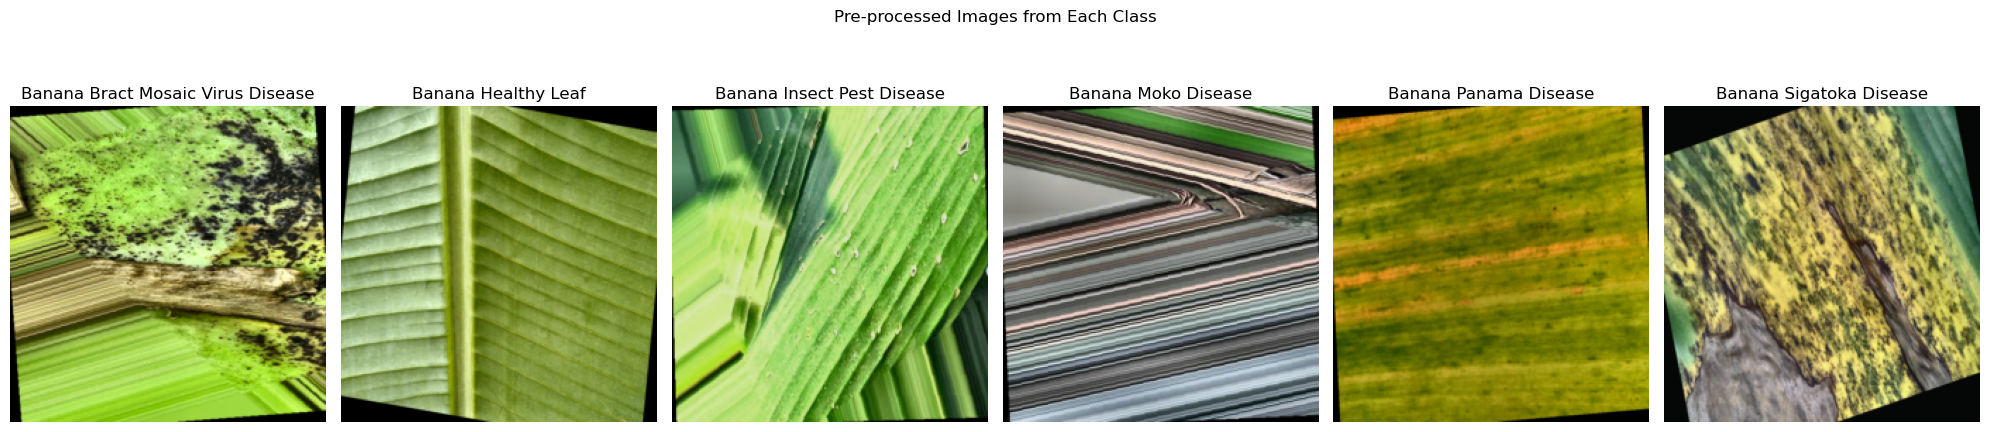

Plotting class-wise metrics...


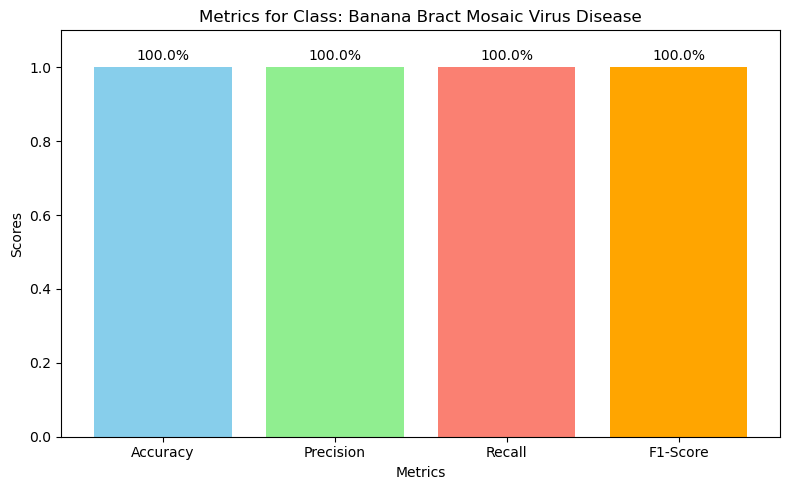

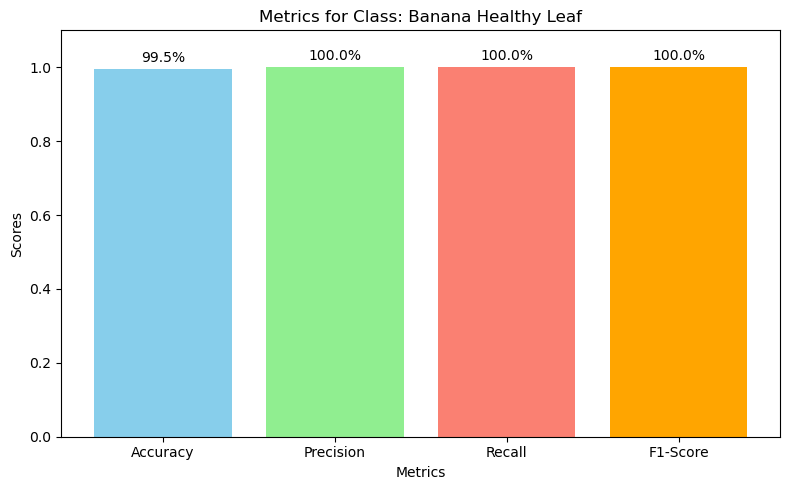

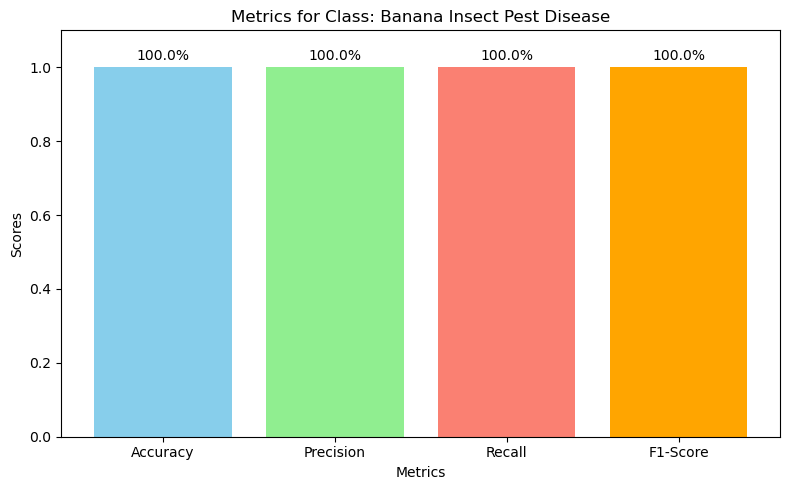

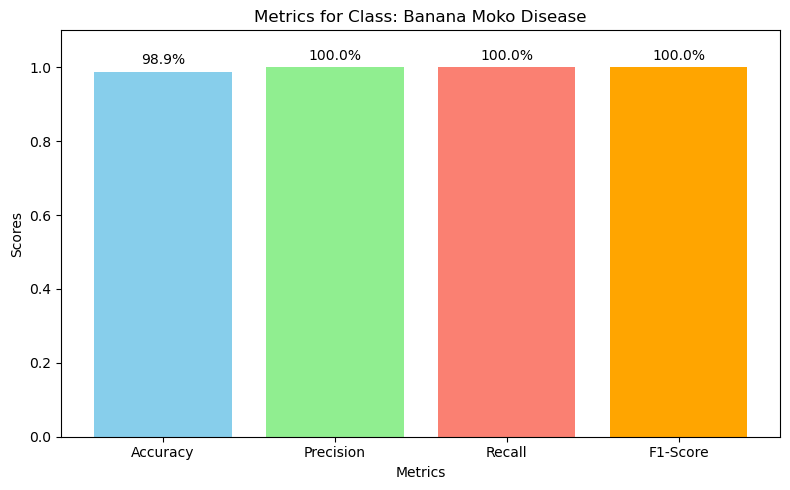

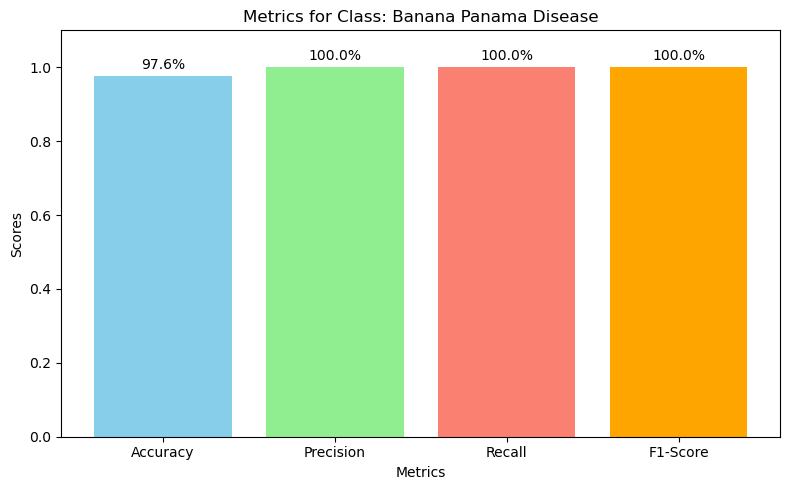

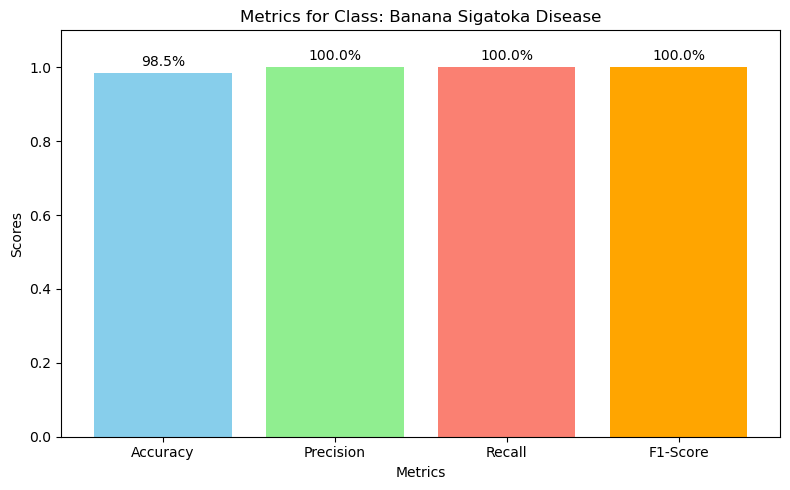

Plotting class-wise accuracy...


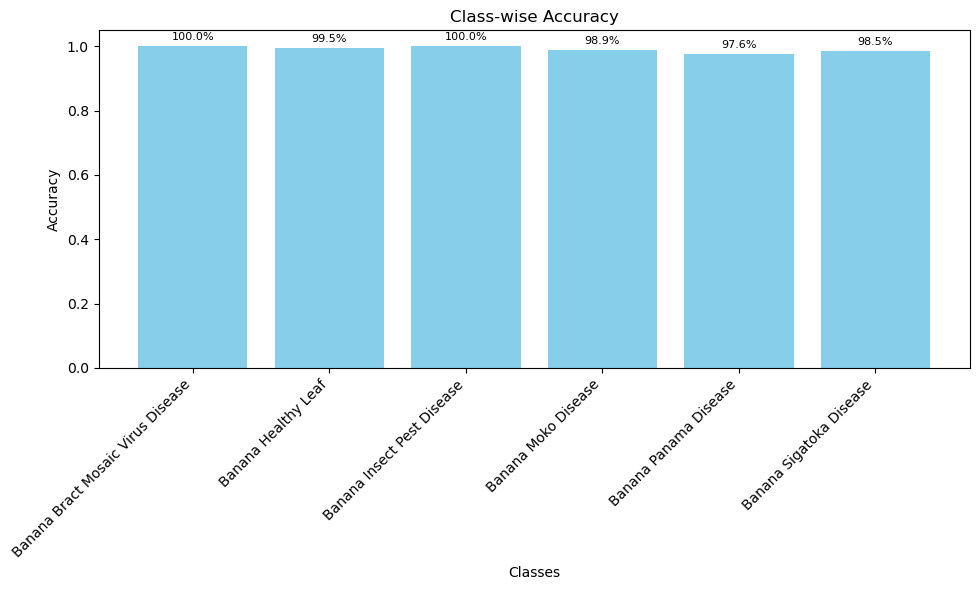

Plotting confusion matrix heatmap...


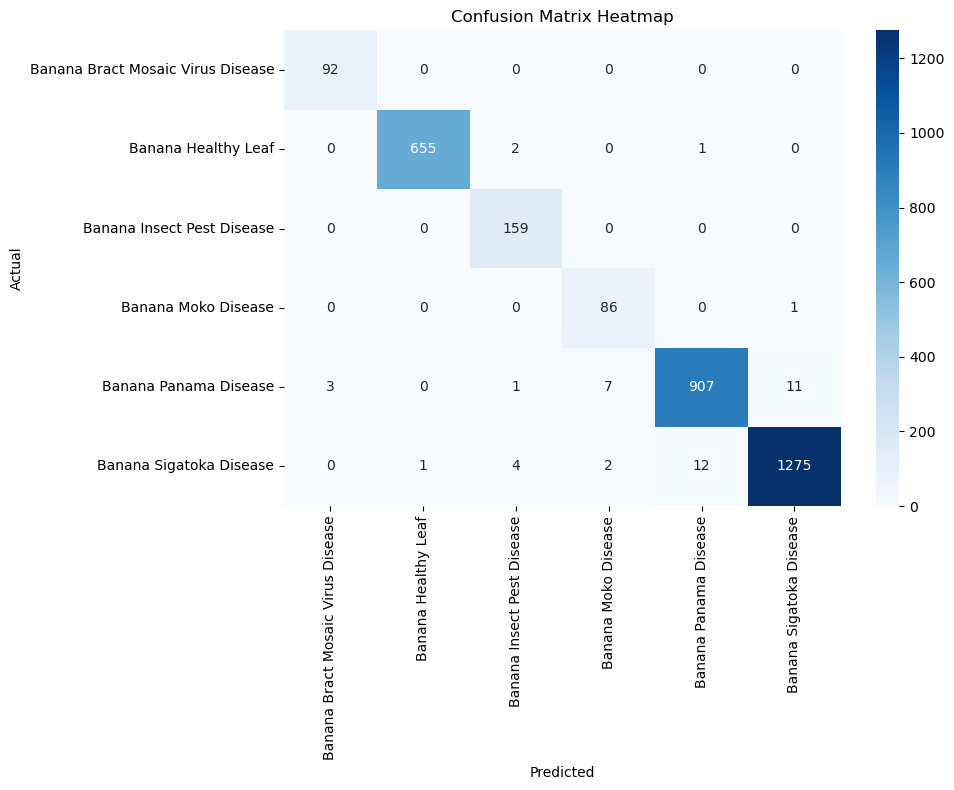

Plotting training loss and validation accuracy vs epoch...


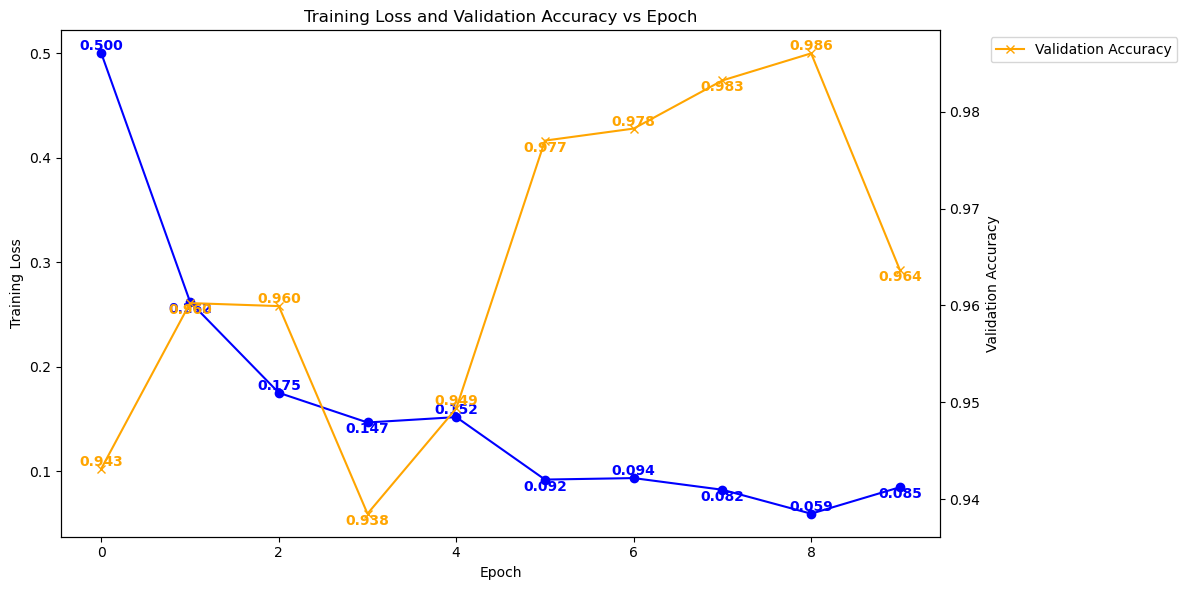

Plotting learning rate vs epoch...


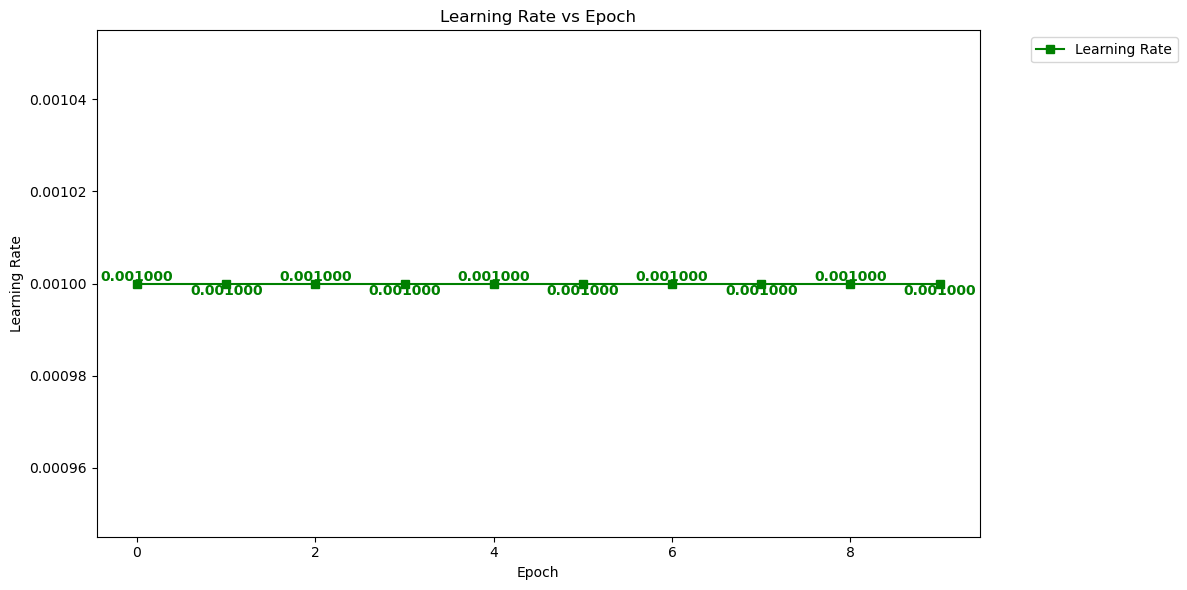

In [1]:
# Import necessary libraries
import random
import torch
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from torchvision.models import ResNet50_Weights
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms
import torch.optim as optim
import seaborn as sns
from torch.amp import GradScaler, autocast  # Import for mixed precision

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset Class
class BananaDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.apply_clahe(image)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

    def apply_clahe(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        return cv2.cvtColor(limg, cv2.COLOR_Lab2RGB)


# Transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Model Class
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Freeze earlier layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layers layer3 and layer4
        for param in self.model.layer3.parameters():
            param.requires_grad = True
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the fully connected layer
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)


# Training Function with Mixed Precision
def train_with_honey_badger(model, train_loader, val_loader, class_weights, num_epochs=10, lr=1e-3):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)
    scaler = GradScaler()  # Correct initialization of GradScaler

    best_accuracy = 0.0
    best_cm = None
    all_val_accuracies = []
    all_learning_rates = []
    all_train_losses = []
    all_cm = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Mixed Precision Forward Pass
            with autocast(device_type='cuda'):  # Correct usage of autocast
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Backward Pass with GradScaler
            scaler.scale(loss).backward()  # Scale loss and backpropagate
            scaler.step(optimizer)  # Update weights
            scaler.update()  # Update scaler for next iteration

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        all_train_losses.append(avg_train_loss)

        current_lr = optimizer.param_groups[0]['lr']
        all_learning_rates.append(current_lr)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Learning Rate: {current_lr:.6f}")

        val_accuracy, epoch_cm = validate_model(model, val_loader)
        all_val_accuracies.append(val_accuracy)
        all_cm.append(epoch_cm)

        print(f"Validation Accuracy for Epoch {epoch+1}: {val_accuracy * 100:.2f}%")
        print("Confusion Matrix for Epoch", epoch + 1)
        print(epoch_cm)

        scheduler.step(val_accuracy)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_cm = epoch_cm
            torch.save(model.state_dict(), "BDD_CNN_CLAHE_HBOA_L34.pth")
            print(f"Best model saved with Validation Accuracy: {best_accuracy * 100:.2f}%")

    avg_cm = np.mean(np.array(all_cm), axis=0)
    print("Average Confusion Matrix across all epochs:")
    print(avg_cm)

    print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%")
    return all_val_accuracies, all_learning_rates, all_train_losses, all_cm, best_cm


# Validation Function
def validate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    cm = np.zeros((6, 6), dtype=int)

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, cm


# Function to Display Pre-processed Images
def display_preprocessed_images(dataset, class_names):
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))
    fig.suptitle("Pre-processed Images from Each Class")

    for i, class_name in enumerate(class_names):
        for idx, (image, label) in enumerate(dataset):
            if label == i:
                image = image.permute(1, 2, 0).numpy()
                image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                image = np.clip(image, 0, 1)
                axes[i].imshow(image)
                axes[i].set_title(class_name)
                axes[i].axis('off')
                break

    plt.tight_layout()
    plt.show()


# Function to plot class-wise metrics (separate graphs for each class)
def plot_class_wise_metrics(best_cm, class_names):
    # Calculate class-wise metrics
    precision = precision_score(np.arange(len(class_names)), np.argmax(best_cm, axis=1), average=None)
    recall = recall_score(np.arange(len(class_names)), np.argmax(best_cm, axis=1), average=None)
    f1 = f1_score(np.arange(len(class_names)), np.argmax(best_cm, axis=1), average=None)
    accuracy = np.diag(best_cm) / np.sum(best_cm, axis=1)

    # Plot separate graphs for each class
    for i, class_name in enumerate(class_names):
        fig, ax = plt.subplots(figsize=(8, 5))
        metrics = [accuracy[i], precision[i], recall[i], f1[i]]
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        colors = ['skyblue', 'lightgreen', 'salmon', 'orange']

        bars = ax.bar(metric_names, metrics, color=colors)

        # Add percentage values inside the bars
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1%}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Scores')
        ax.set_title(f'Metrics for Class: {class_name}')
        ax.set_ylim(0, 1.1)  # Set y-axis limit to 110% for better visualization
        plt.tight_layout()
        plt.show()


# Function to plot class-wise accuracy
def plot_class_wise_accuracy(best_cm, class_names):
    class_accuracy = np.diag(best_cm) / np.sum(best_cm, axis=1)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, class_accuracy, color='skyblue')

    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.1%}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8)  # Reduce font size for better fit

    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.title('Class-wise Accuracy')
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better visibility
    plt.tight_layout()
    plt.show()


# Function to plot confusion matrix heatmap
def plot_confusion_matrix_heatmap(best_cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.tight_layout()
    plt.show()


# Function to plot training loss and validation accuracy vs epoch
def plot_training_validation_curves(all_train_losses, all_val_accuracies):
    plt.figure(figsize=(12, 6))

    # Plot Training Loss
    plt.plot(all_train_losses, label='Training Loss', color='blue', marker='o', linestyle='-')

    for i, value in enumerate(all_train_losses):
        plt.text(i, value, f'{value:.3f}', ha='center', va='bottom' if i % 2 == 0 else 'top',
                 fontsize=10, color='blue', fontweight='bold')

    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss and Validation Accuracy vs Epoch')

    # Second Y-Axis for Validation Accuracy
    ax2 = plt.gca().twinx()
    ax2.plot(all_val_accuracies, label='Validation Accuracy', color='orange', marker='x', linestyle='-')

    for i, value in enumerate(all_val_accuracies):
        plt.text(i, value, f'{value:.3f}', ha='center', va='bottom' if i % 2 == 0 else 'top',
                 fontsize=10, color='orange', fontweight='bold')

    ax2.set_ylabel('Validation Accuracy')

    # Adjust legend placement
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()


# Function to plot learning rate vs epoch
def plot_learning_rate_vs_epoch(all_learning_rates):
    plt.figure(figsize=(12, 6))

    # Plot Learning Rate
    plt.plot(all_learning_rates, label='Learning Rate', color='green', marker='s', linestyle='-')

    for i, value in enumerate(all_learning_rates):
        plt.text(i, value, f'{value:.6f}', ha='center', va='bottom' if i % 2 == 0 else 'top',
                 fontsize=10, color='green', fontweight='bold')

    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs Epoch')

    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()


# Main Function
def main():
    dataset_path = r'C:\Users\syhaw\Downloads\Mega-Project\Dataset\HKC'
    image_paths, labels = [], []
    class_names = []

    for label, class_name in enumerate(os.listdir(dataset_path)):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            class_names.append(class_name)
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                if image_path.lower().endswith(('png', 'jpg', 'jpeg')):
                    image_paths.append(image_path)
                    labels.append(label)

    train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
    train_dataset = BananaDiseaseDataset(train_paths, train_labels, transform=train_transform)
    val_dataset = BananaDiseaseDataset(val_paths, val_labels, transform=val_transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    num_classes = 6
    model = CNNModel(num_classes).to(device)

    print("Training the model...")
    all_val_accuracies, all_learning_rates, all_train_losses, all_cm, best_cm = train_with_honey_badger(model, train_loader, val_loader, class_weights, num_epochs=10, lr=1e-3)

    print("Displaying pre-processed images...")
    display_preprocessed_images(train_dataset, class_names)

    print("Plotting class-wise metrics...")
    plot_class_wise_metrics(best_cm, class_names)

    print("Plotting class-wise accuracy...")
    plot_class_wise_accuracy(best_cm, class_names)

    print("Plotting confusion matrix heatmap...")
    plot_confusion_matrix_heatmap(best_cm, class_names)

    print("Plotting training loss and validation accuracy vs epoch...")
    plot_training_validation_curves(all_train_losses, all_val_accuracies)

    print("Plotting learning rate vs epoch...")
    plot_learning_rate_vs_epoch(all_learning_rates)


# Entry point
if __name__ == "__main__":
    main()